In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_13_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 100)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f94dc9ab930> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(10518)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

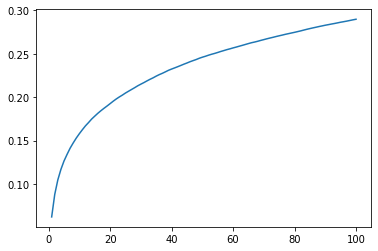

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.0621, 0.0880, 0.1047, 0.1167, 0.1264, 0.1340, 0.1412, 0.1473, 0.1529,
        0.1579, 0.1626, 0.1670, 0.1708, 0.1748, 0.1781, 0.1814, 0.1843, 0.1871,
        0.1898, 0.1925, 0.1953, 0.1979, 0.2002, 0.2024, 0.2047, 0.2068, 0.2089,
        0.2109, 0.2131, 0.2150, 0.2168, 0.2187, 0.2206, 0.2223, 0.2242, 0.2260,
        0.2275, 0.2292, 0.2309, 0.2324, 0.2337, 0.2351, 0.2365, 0.2380, 0.2393,
        0.2408, 0.2421, 0.2433, 0.2448, 0.2460, 0.2471, 0.2483, 0.2494, 0.2504,
        0.2515, 0.2526, 0.2537, 0.2547, 0.2557, 0.2567, 0.2577, 0.2587, 0.2597,
        0.2607, 0.2617, 0.2627, 0.2635, 0.2644, 0.2654, 0.2663, 0.2672, 0.2681,
        0.2689, 0.2698, 0.2707, 0.2715, 0.2724, 0.2731, 0.2739, 0.2747, 0.2755,
        0.2763, 0.2773, 0.2782, 0.2790, 0.2798, 0.2806, 0.2814, 0.2821, 0.2829,
        0.2835, 0.2842, 0.2849, 0.2856, 0.2863, 0.2869, 0.2876, 0.2883, 0.2891,
        0.2897])

In [18]:
percentages.max()

tensor(0.2897)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.49576304, 0.47601613, 0.46300506, 0.45336831, 0.44581589,
       0.43977804, 0.43484272, 0.43042966, 0.42657145, 0.42315183,
       0.4201913 , 0.41750176, 0.41497162, 0.41258739, 0.41046515,
       0.40852109, 0.40659733, 0.40484631, 0.40320315, 0.40171575,
       0.40027749, 0.39890851, 0.39758566, 0.39625518, 0.3950628 ,
       0.39390059, 0.39272736, 0.39161621, 0.39057314, 0.38952343,
       0.38848087, 0.3875055 , 0.38659336, 0.38566071, 0.38476229,
       0.38389672, 0.38305879, 0.38225455, 0.38146566, 0.38071148,
       0.37995392, 0.37918786, 0.37848943, 0.37776718, 0.37706811,
       0.37640328, 0.37570707, 0.3750545 , 0.37443182, 0.37381551,
       0.37323981, 0.37266536, 0.37207648, 0.37152439, 0.37097231,
       0.37041337, 0.36987787, 0.36935473, 0.36885573, 0.36834521,
       0.36783943, 0.36733863, 0.36683995, 0.3663611 , 0.36589825,
       0.36544567, 0.36498246, 0.36453043, 0.36408697, 0.3636674 ,
       0.36323819, 0.36282968, 0.36241044, 0.36199599, 0.36159

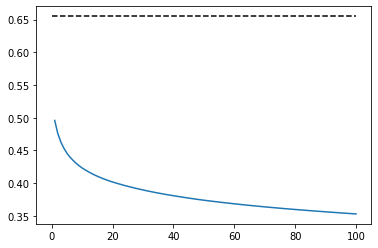

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f94c0ecb030> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(18248)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8714843601283064

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839, 140574, ...,  65762, 125495, 102747],
       [     1, 154949,   9558, ...,  57639, 156314, 110630],
       [     2, 136945, 148688, ...,  30408,  86170,  11661],
       ...,
       [169340, 152563, 103756, ..., 155706,   1211, 137397],
       [169341, 146945, 103121, ..., 151378, 138365,  53132],
       [169342,   1461, 168387, ..., 114386, 101423,  17254]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.7429687202566129

In [40]:
distances

array([[1.0000001 , 0.93592757, 0.9147445 , ..., 0.7449909 , 0.7446943 ,
        0.74466866],
       [0.99999994, 0.99996036, 0.9999537 , ..., 0.99992955, 0.99992913,
        0.99992913],
       [0.99999964, 0.9999633 , 0.99995464, ..., 0.9998968 , 0.9998965 ,
        0.99989593],
       ...,
       [1.        , 0.92441505, 0.89834297, ..., 0.79727566, 0.79662585,
        0.7963075 ],
       [1.        , 0.99251974, 0.9916253 , ..., 0.9783965 , 0.9783226 ,
        0.9782348 ],
       [1.0000001 , 0.9998521 , 0.99984914, ..., 0.99968636, 0.9996849 ,
        0.9996846 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

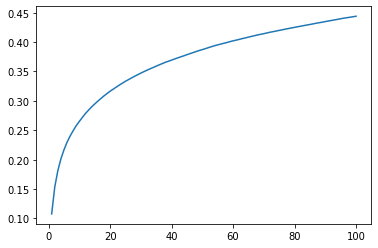

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.1077, 0.1534, 0.1811, 0.2013, 0.2167, 0.2296, 0.2402, 0.2494, 0.2579,
        0.2651, 0.2719, 0.2786, 0.2843, 0.2898, 0.2947, 0.2995, 0.3039, 0.3084,
        0.3124, 0.3164, 0.3199, 0.3234, 0.3268, 0.3301, 0.3333, 0.3362, 0.3391,
        0.3419, 0.3445, 0.3472, 0.3497, 0.3521, 0.3545, 0.3567, 0.3590, 0.3613,
        0.3635, 0.3657, 0.3674, 0.3694, 0.3713, 0.3731, 0.3749, 0.3767, 0.3786,
        0.3803, 0.3821, 0.3839, 0.3856, 0.3872, 0.3888, 0.3906, 0.3922, 0.3938,
        0.3952, 0.3965, 0.3979, 0.3992, 0.4008, 0.4021, 0.4033, 0.4046, 0.4059,
        0.4071, 0.4084, 0.4097, 0.4109, 0.4122, 0.4132, 0.4143, 0.4155, 0.4167,
        0.4177, 0.4188, 0.4198, 0.4209, 0.4220, 0.4230, 0.4240, 0.4250, 0.4260,
        0.4270, 0.4280, 0.4290, 0.4299, 0.4309, 0.4320, 0.4329, 0.4338, 0.4349,
        0.4358, 0.4367, 0.4377, 0.4387, 0.4397, 0.4406, 0.4414, 0.4422, 0.4431,
        0.4439])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.55880078, 0.53656484, 0.52175171, 0.51070165, 0.50211701,
       0.49492844, 0.48894678, 0.48388256, 0.47948641, 0.47567481,
       0.47231896, 0.46920845, 0.46634209, 0.46371101, 0.46141264,
       0.45922292, 0.45719078, 0.45528241, 0.45356217, 0.45191623,
       0.45029179, 0.44886951, 0.44744895, 0.44613521, 0.44487271,
       0.44363556, 0.44246905, 0.44132323, 0.440277  , 0.43921941,
       0.43821863, 0.43728852, 0.43632549, 0.43545297, 0.43461951,
       0.43381103, 0.43298704, 0.43219756, 0.43146689, 0.43071872,
       0.42998688, 0.42930648, 0.42863026, 0.42797002, 0.42731393,
       0.42668032, 0.42609567, 0.42551865, 0.4249289 , 0.4243644 ,
       0.42380895, 0.4232668 , 0.42274544, 0.42224602, 0.42171709,
       0.42122391, 0.42073427, 0.42025896, 0.41979527, 0.41933344,
       0.4188766 , 0.41843363, 0.41801438, 0.41757493, 0.41715026,
       0.41673042, 0.41630918, 0.41590145, 0.41552001, 0.41515437,
       0.41479003, 0.41441351, 0.41403874, 0.41367951, 0.41332

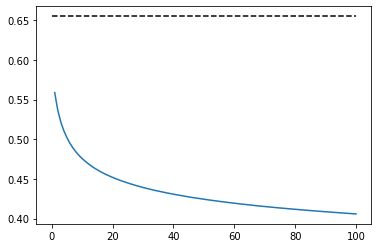

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f94c0e2a3f0> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(13136)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

4.036087425687583

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[153547, 167678, 105909, ..., 139341, 105693,  17536],
       [125591, 144611, 118436, ..., 127225, 105792,  35808],
       [ 60401,  10299,  80156, ...,   4253, 156200, 139482],
       ...,
       [ 22064, 103381,  14702, ...,  38886, 125364,  43354],
       [ 61100,  70820,  73485, ...,  67657, 135300, 105878],
       [153547, 167678, 105909, ..., 116967,  82519,  21387]])

In [61]:
sum(embeddings[0] * embeddings[411])

7.072174851375166

In [62]:
distances

array([[4.8448421e+01, 4.5441208e+01, 4.4597652e+01, ..., 3.3129341e+01,
        3.3129314e+01, 3.3113579e+01],
       [4.3531219e+04, 4.3041316e+04, 4.2725340e+04, ..., 3.3510137e+04,
        3.3509453e+04, 3.3487055e+04],
       [2.0002512e+04, 1.9896592e+04, 1.9865498e+04, ..., 1.6123305e+04,
        1.6116617e+04, 1.6112759e+04],
       ...,
       [5.7730494e+00, 5.5119042e+00, 5.1378169e+00, ..., 4.1334352e+00,
        4.1316991e+00, 4.1284442e+00],
       [9.2591467e+00, 8.9497757e+00, 8.7514095e+00, ..., 7.1251888e+00,
        7.1016569e+00, 7.0826478e+00],
       [1.4542550e+04, 1.4005992e+04, 1.3665403e+04, ..., 1.0006274e+04,
        9.9928877e+03, 9.9823584e+03]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

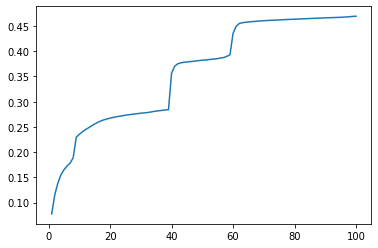

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.0776, 0.1151, 0.1383, 0.1551, 0.1651, 0.1724, 0.1782, 0.1890, 0.2297,
        0.2354, 0.2403, 0.2447, 0.2483, 0.2521, 0.2559, 0.2591, 0.2619, 0.2641,
        0.2658, 0.2674, 0.2688, 0.2700, 0.2712, 0.2721, 0.2732, 0.2741, 0.2749,
        0.2757, 0.2764, 0.2772, 0.2777, 0.2785, 0.2793, 0.2805, 0.2813, 0.2821,
        0.2829, 0.2836, 0.2844, 0.3563, 0.3702, 0.3751, 0.3770, 0.3782, 0.3788,
        0.3794, 0.3800, 0.3808, 0.3816, 0.3822, 0.3826, 0.3834, 0.3841, 0.3847,
        0.3854, 0.3867, 0.3876, 0.3900, 0.3930, 0.4354, 0.4494, 0.4550, 0.4566,
        0.4574, 0.4581, 0.4587, 0.4592, 0.4596, 0.4602, 0.4605, 0.4609, 0.4612,
        0.4616, 0.4618, 0.4621, 0.4624, 0.4628, 0.4630, 0.4633, 0.4635, 0.4638,
        0.4640, 0.4644, 0.4646, 0.4649, 0.4652, 0.4654, 0.4657, 0.4659, 0.4662,
        0.4664, 0.4667, 0.4669, 0.4670, 0.4673, 0.4676, 0.4680, 0.4686, 0.4691,
        0.4694])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.53971525, 0.45116716, 0.47475046, 0.51145604, 0.53105827,
       0.53608062, 0.52764761, 0.51616542, 0.52119794, 0.503151  ,
       0.50020641, 0.49114076, 0.48585552, 0.48709466, 0.48745367,
       0.47737949, 0.48091187, 0.48181928, 0.48451896, 0.48876806,
       0.48796483, 0.48748452, 0.48774227, 0.48264518, 0.47810964,
       0.47784606, 0.48089512, 0.47915431, 0.47930022, 0.48184356,
       0.48352028, 0.4864956 , 0.48623101, 0.48547553, 0.48820543,
       0.48857398, 0.48944817, 0.49074581, 0.4893326 , 0.48834451,
       0.48546744, 0.4862505 , 0.48844254, 0.48602795, 0.4844873 ,
       0.48308938, 0.48174428, 0.48063644, 0.48093261, 0.48081066,
       0.48024354, 0.48153247, 0.4833244 , 0.48296029, 0.48337151,
       0.48189906, 0.48198689, 0.47984544, 0.47844006, 0.47843243,
       0.47872119, 0.47888167, 0.48017525, 0.48133854, 0.48243033,
       0.48152548, 0.48168598, 0.48185131, 0.4820543 , 0.48266637,
       0.48240861, 0.48222198, 0.4811411 , 0.47919032, 0.48090

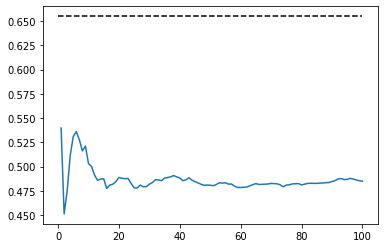

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

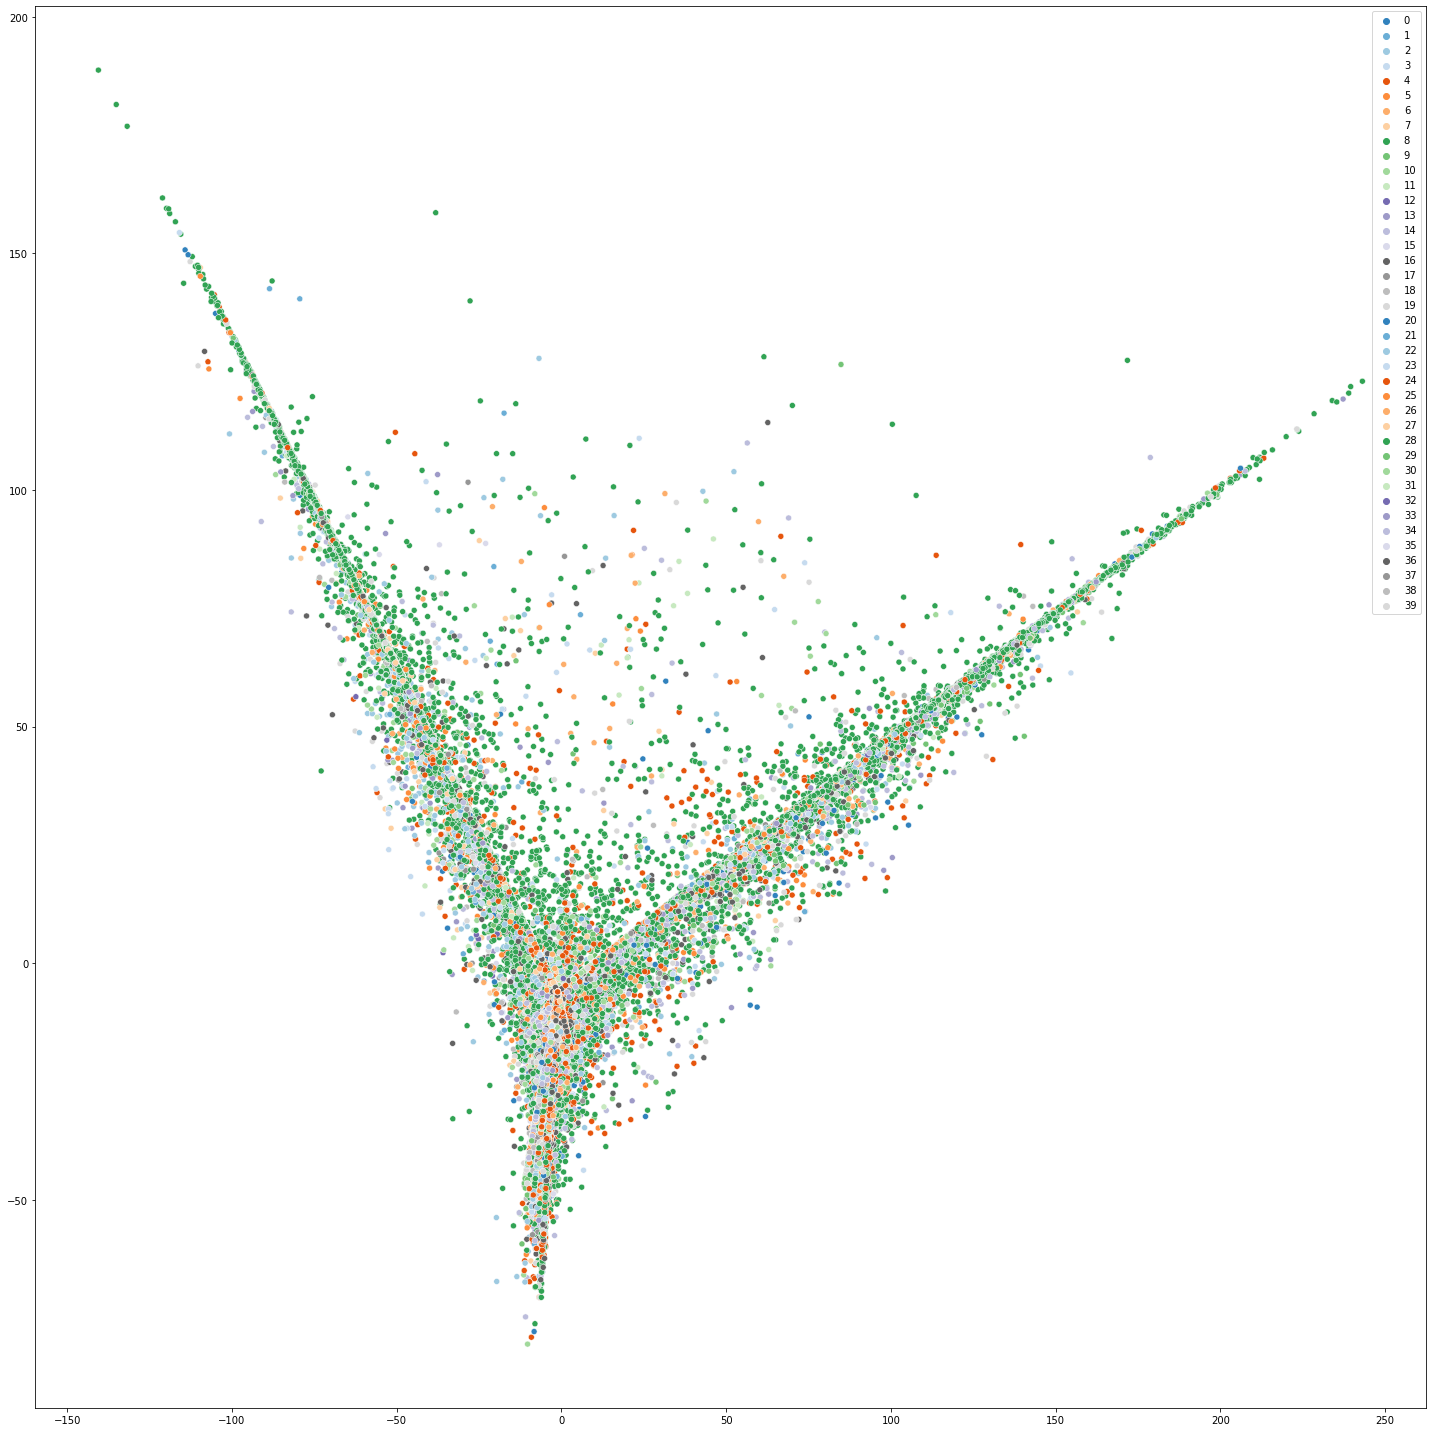

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

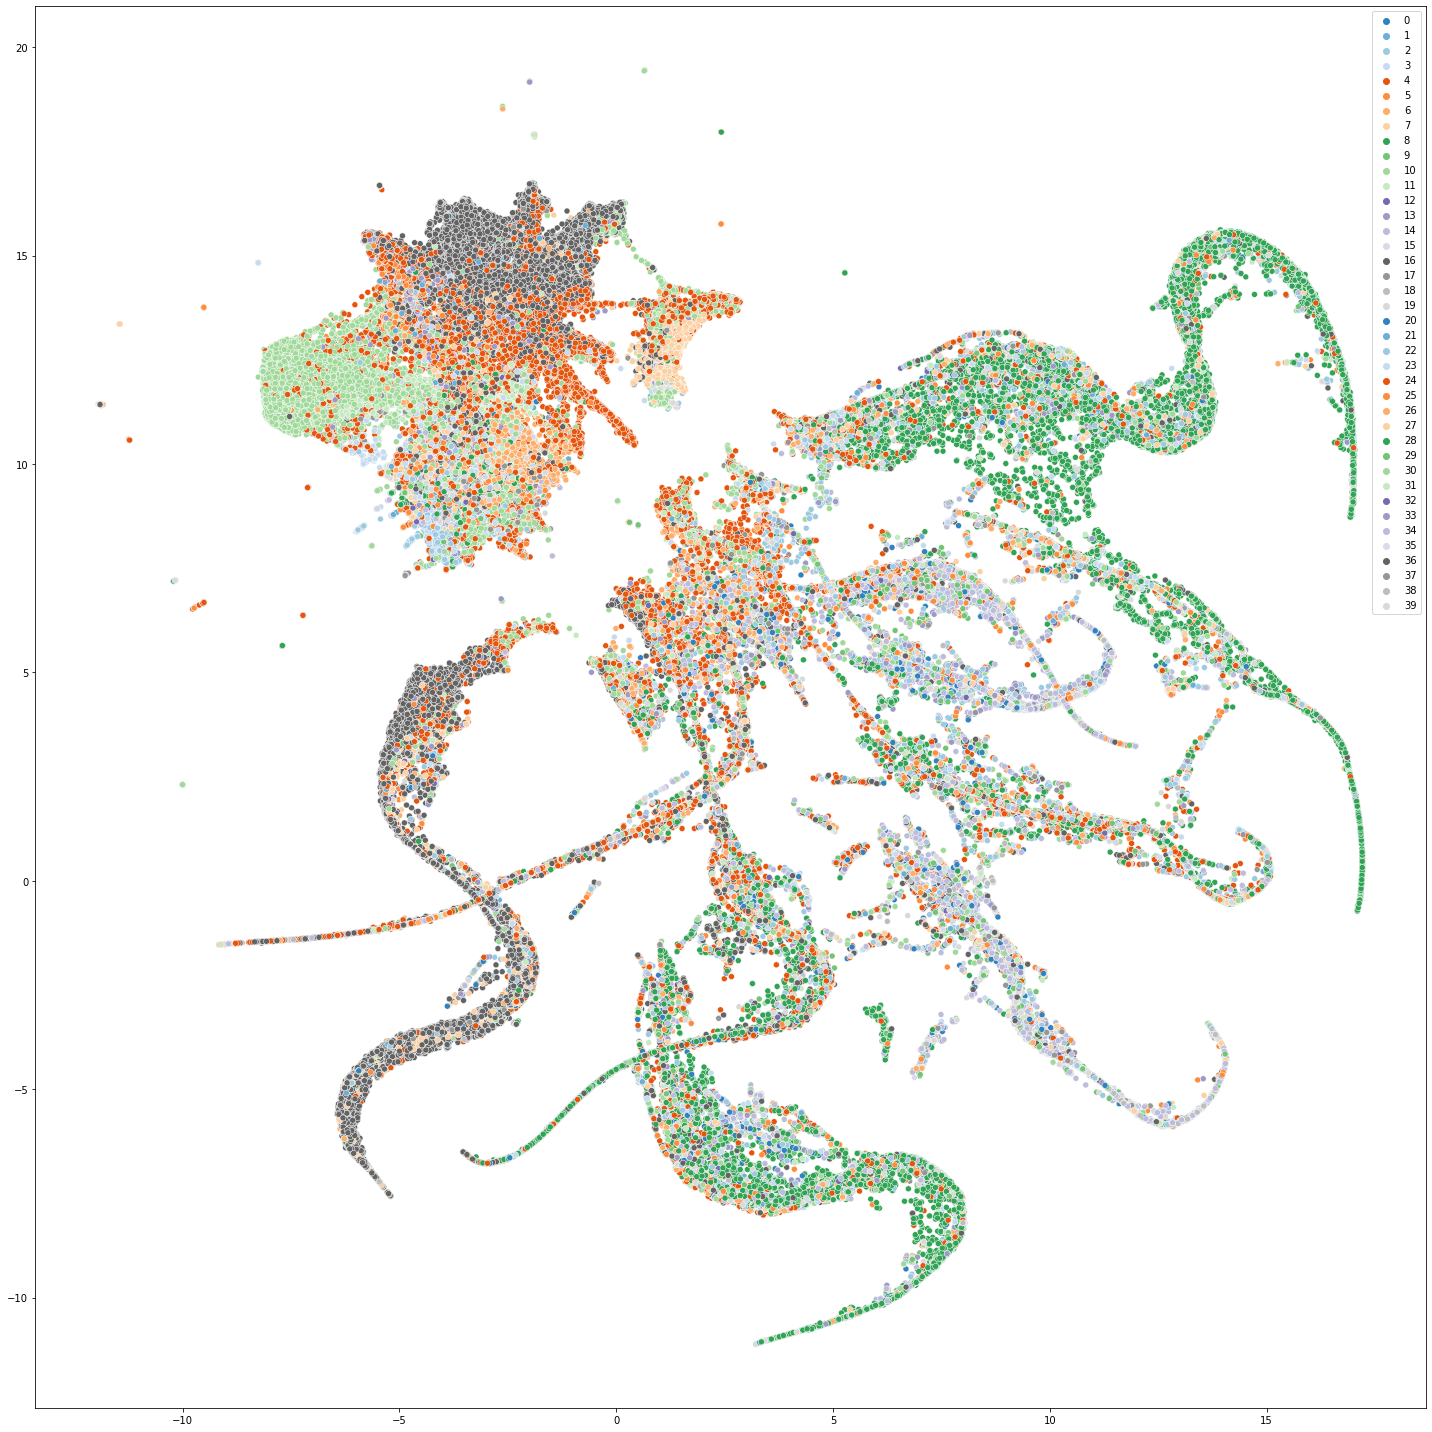

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

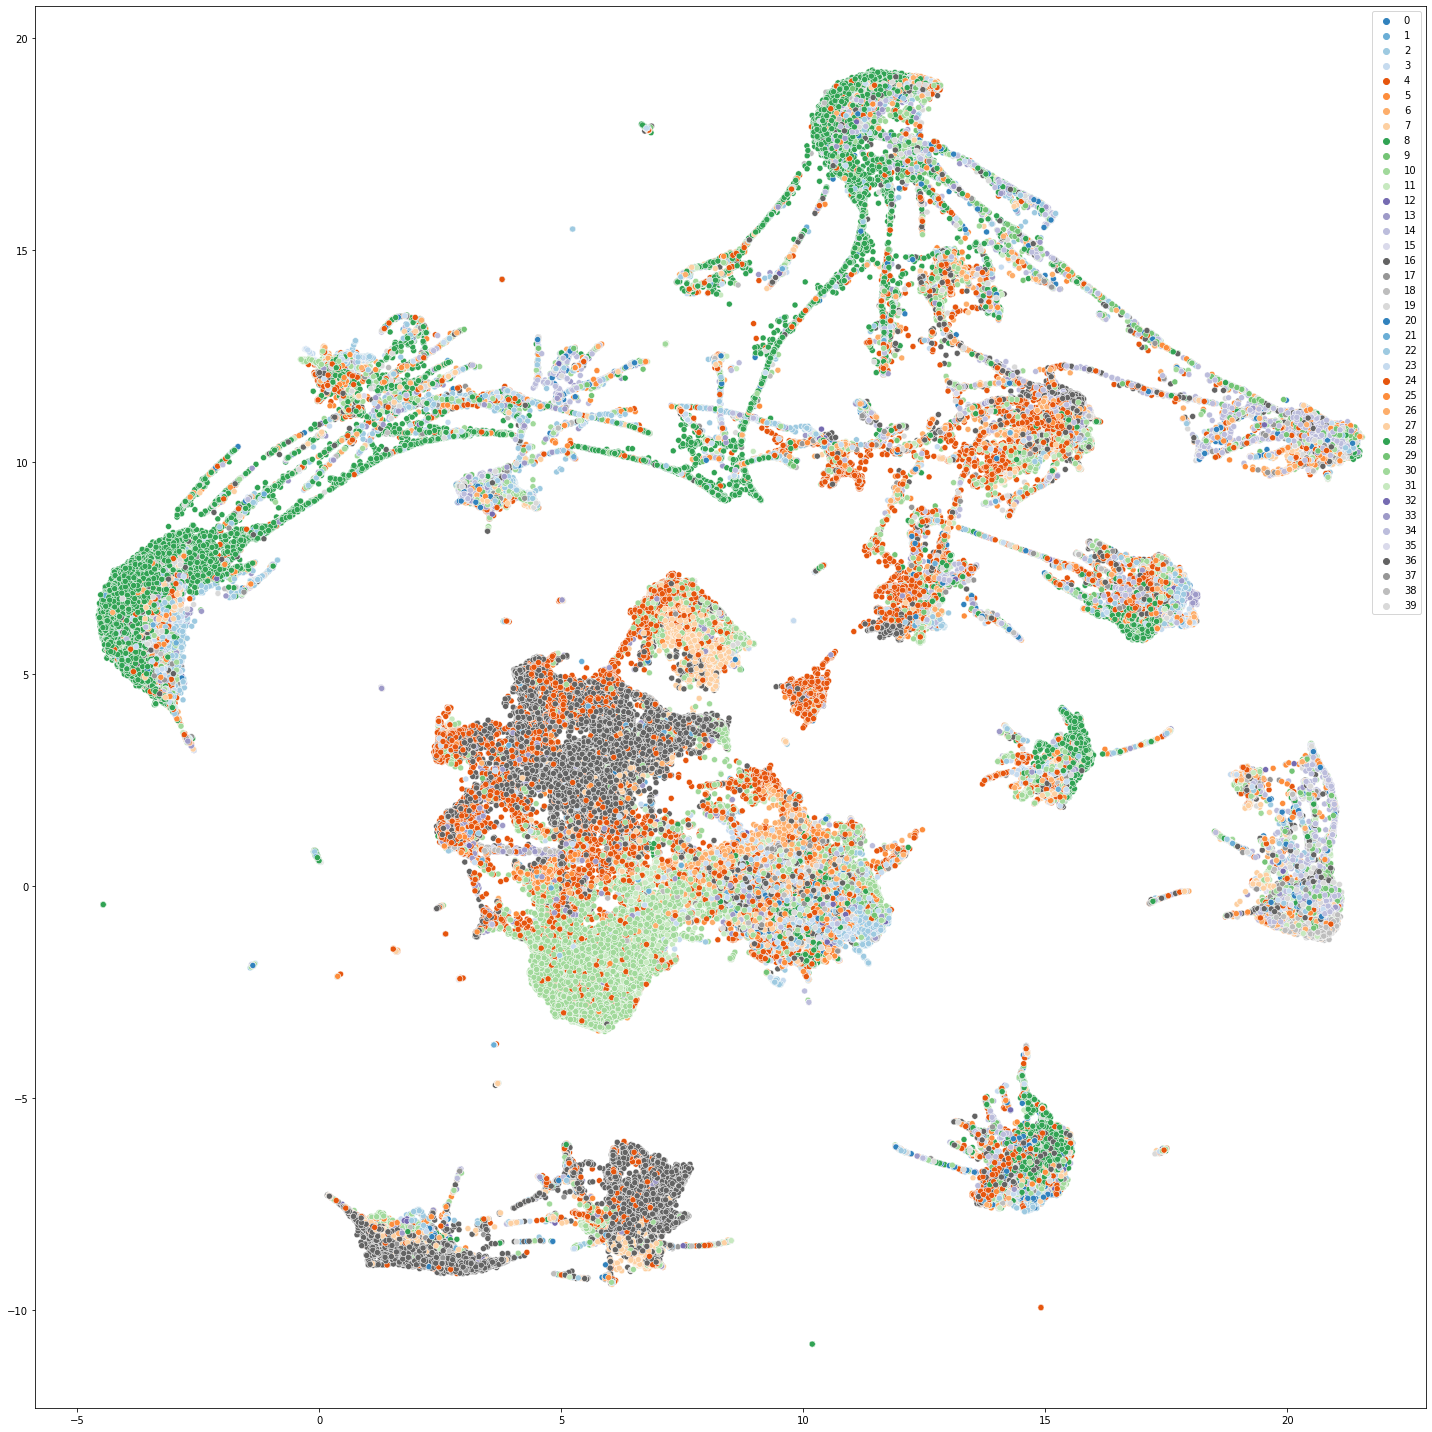

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()